# Bayesian Neural Network Pipeline for LIAR Dataset


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load and Preprocess Data

In [ ]:
!pip install pyro-ppl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 103.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninst

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro import poutine
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.optim import ClippedAdam

In [ ]:
def load_and_preprocess(path):
    columns = [
        'id', 'label', 'statement', 'subject', 'speaker', 'job', 'state', 'party',
        'barely_true_counts', 'false_counts', 'half_true_counts',
        'mostly_true_counts', 'pants_on_fire_counts', 'context']
    df = pd.read_csv(path, sep='\t', header=None, names=columns)
    label_map = {'pants-fire': 0, 'false': 0, 'barely-true': 0, 'half-true': 0, 'mostly-true': 1, 'true': 1}
    df['label'] = df['label'].map(label_map)
    metadata_cols = ['speaker', 'job', 'state', 'party', 'context']
    df[metadata_cols] = df[metadata_cols].fillna('unknown')
    return df

train_df = load_and_preprocess('/content/drive/MyDrive/Colab Notebooks/Datasets/liar_dataset/train.tsv')
valid_df = load_and_preprocess('/content/drive/MyDrive/Colab Notebooks/Datasets/liar_dataset/valid.tsv')
test_df = load_and_preprocess('/content/drive/MyDrive/Colab Notebooks/Datasets/liar_dataset/test.tsv')

## Encode metadata


In [ ]:
metadata_cols = ['speaker', 'job', 'state', 'party', 'context']
label_encoders = {}
for col in metadata_cols:
    le = LabelEncoder()
    combined = pd.concat([train_df[col], valid_df[col], test_df[col]])
    le.fit(combined)
    label_encoders[col] = le
    for df in [train_df, valid_df, test_df]:
        df[col + '_enc'] = le.transform(df[col])

In [ ]:
credit_cols = [
    'barely_true_counts', 'false_counts', 'half_true_counts',
    'mostly_true_counts', 'pants_on_fire_counts']
for df in [train_df, valid_df, test_df]:
    df[credit_cols] = df[credit_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

## Tokenization

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class LIARDataset(Dataset):
    def __init__(self, df):
        self.texts = list(df['statement'])
        self.metadata = df[[col + '_enc' for col in metadata_cols] + credit_cols].values
        self.labels = list(df['label'])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoded = tokenizer(self.texts[idx], padding='max_length', truncation=True, max_length=64, return_tensors='pt')
        return {
            'input_ids': encoded['input_ids'].squeeze(0),
            'attention_mask': encoded['attention_mask'].squeeze(0),
            'metadata': torch.tensor(self.metadata[idx], dtype=torch.float),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## BERT Embedding + BNN

In [ ]:
class BNNClassifier(PyroModule):
    def __init__(self, bert_dim, meta_dim, hidden_dim, output_dim):
        super().__init__()

        class FrozenBERT(nn.Module):
            def __init__(self):
                super().__init__()
                self.model = BertModel.from_pretrained('bert-base-uncased')
                self.model.eval()
                for p in self.model.parameters():
                    p.requires_grad = False

            def forward(self, input_ids, attention_mask):
                with torch.no_grad():
                    return self.model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]

        self.bert_model = FrozenBERT()

        # using tighter priors (0., 0.05)
        input_dim = bert_dim + meta_dim
        self.fc1 = PyroModule[nn.Linear](input_dim, hidden_dim)
        self.fc1.weight = PyroSample(dist.Normal(0., 0.05).expand([hidden_dim, input_dim]).to_event(2))
        self.fc1.bias = PyroSample(dist.Normal(0., 0.05).expand([hidden_dim]).to_event(1))

        self.fc2 = PyroModule[nn.Linear](hidden_dim, output_dim)
        self.fc2.weight = PyroSample(dist.Normal(0., 0.05).expand([output_dim, hidden_dim]).to_event(2))
        self.fc2.bias = PyroSample(dist.Normal(0., 0.05).expand([output_dim]).to_event(1))

    def forward(self, input_ids, attention_mask, metadata, labels=None):
      bert_output = self.bert_model(input_ids, attention_mask)
      x = torch.cat((bert_output, metadata), dim=1)
      x = F.relu(self.fc1(x))
      logits = self.fc2(x)

      with pyro.plate("data", x.shape[0]):
        pyro.sample("obs", dist.Categorical(logits=logits), obs=labels)
      return logits

## Prepare Dataloaders

In [ ]:
from sklearn.preprocessing import MinMaxScaler

all_meta = [col + '_enc' for col in metadata_cols] + credit_cols
scaler = MinMaxScaler()
scaler.fit(train_df[all_meta])
for df in [train_df, valid_df, test_df]:
    df[all_meta] = scaler.transform(df[all_meta])

In [ ]:
train_dataset = LIARDataset(train_df)
valid_dataset = LIARDataset(valid_df)
train_loader = DataLoader(train_dataset, batch_size=12, shuffle=True) # increasing batch_size from 8 to 12
valid_loader = DataLoader(valid_dataset, batch_size=12)

## Deterministic Classifier Pre-training (to set up Guide)

In [ ]:
bert_dim = 768
meta_dim = len(metadata_cols) + len(credit_cols)
hidden_dim = 256 # increased hidden layers
output_dim = 2

In [ ]:
class DeterministicClassifier(nn.Module):
    def __init__(self, bert_dim, meta_dim, hidden_dim, output_dim):
        super().__init__()
        self.bert_model = BertModel.from_pretrained("bert-base-uncased")
        for p in self.bert_model.parameters():
            p.requires_grad = False
        self.bert_model.eval()

        self.fc1 = nn.Linear(bert_dim + meta_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, input_ids, attention_mask, metadata):
        with torch.no_grad():
            bert_output = self.bert_model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
        x = torch.cat((bert_output, metadata), dim=1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [ ]:
model = DeterministicClassifier(bert_dim, meta_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

def train_epoch_det(dataloader):
    model.train()
    total_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        logits = model(batch['input_ids'], batch['attention_mask'], batch['metadata'])
        loss = loss_fn(logits, batch['label'])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
batch = next(iter(train_loader))

model.eval()

with torch.no_grad():
    logits = model(batch['input_ids'], batch['attention_mask'], batch['metadata'])

loss_fn = nn.CrossEntropyLoss()
loss = loss_fn(logits, batch['label'])

print(f" Deterministic model loss (single batch): {loss.item():.4f}")

 Deterministic model loss (single batch): 0.7311


In [ ]:
num_epochs = 3
for epoch in range(num_epochs):
    avg_loss = train_epoch_det(train_loader)
    print(f"Epoch {epoch+1} Completed - Avg Loss: {avg_loss:.4f}")

Epoch 1 Completed - Avg Loss: 0.6330
Epoch 2 Completed - Avg Loss: 0.6211
Epoch 3 Completed - Avg Loss: 0.6146


## Pyro Guide, Optimizer, and SVI

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="pyro")

In [ ]:
bnn_model = BNNClassifier(bert_dim, meta_dim, hidden_dim, output_dim)
guide = AutoDiagonalNormal(bnn_model)

In [ ]:
deterministic_state_dict = model.state_dict()
guide_param_state_dict = guide.state_dict()

for name, param in deterministic_state_dict.items():
    if 'fc' in name:
        guide_loc_name = name.replace(".weight", ".weight_loc").replace(".bias", ".bias_loc")
        if guide_loc_name in guide_param_state_dict:
            if guide_param_state_dict[guide_loc_name].shape == param.shape:
                guide_param_state_dict[guide_loc_name] = param
                print(f"Initialized guide parameter: {guide_loc_name} from deterministic: {name}")
            else:
                print(f"Warning: Shape mismatch for {name}. Skipping initialization.")
        else:
            print(f"Warning: Could not find corresponding guide location parameter for: {name}")
    else:
        print(f"Skipping initialization for BERT parameter: {name}")




Skipping initialization for BERT parameter: bert_model.embeddings.word_embeddings.weight
Skipping initialization for BERT parameter: bert_model.embeddings.position_embeddings.weight
Skipping initialization for BERT parameter: bert_model.embeddings.token_type_embeddings.weight
Skipping initialization for BERT parameter: bert_model.embeddings.LayerNorm.weight
Skipping initialization for BERT parameter: bert_model.embeddings.LayerNorm.bias
Skipping initialization for BERT parameter: bert_model.encoder.layer.0.attention.self.query.weight
Skipping initialization for BERT parameter: bert_model.encoder.layer.0.attention.self.query.bias
Skipping initialization for BERT parameter: bert_model.encoder.layer.0.attention.self.key.weight
Skipping initialization for BERT parameter: bert_model.encoder.layer.0.attention.self.key.bias
Skipping initialization for BERT parameter: bert_model.encoder.layer.0.attention.self.value.weight
Skipping initialization for BERT parameter: bert_model.encoder.layer.0.a

In [ ]:
for name, param in guide_param_state_dict.items():
    if '_scale' in name:
        param.data.fill_(0.1)
        print(f"Initialized guide parameter: {name} with small scale.")

guide.load_state_dict(guide_param_state_dict)

<All keys matched successfully>

In [ ]:
optimizer = ClippedAdam({'lr': 5e-4}) # changed learning rate from 1e-3 to 5e-4
svi = SVI(bnn_model, guide, optimizer, loss=TraceMeanField_ELBO())

## Training Loop

In [ ]:
batch = next(iter(train_loader))
logits = model(
    batch['input_ids'],
    batch['attention_mask'],
    batch['metadata'],
)
print("Logits range:", logits.min().item(), logits.max().item())

loss_fn = nn.CrossEntropyLoss()
loss = loss_fn(logits, batch['label'])

print(f" Deterministic model loss (single batch): {loss.item():.4f}")

Logits range: -1.227121114730835 1.1523164510726929
 Deterministic model loss (single batch): 0.4656


In [ ]:
model.eval()
with torch.no_grad():
    logits = model(
        batch['input_ids'],
        batch['attention_mask'],
        batch['metadata']
    )
    print("Logits:", logits)
    print("Min:", logits.min().item(), "Max:", logits.max().item())

Logits: tensor([[ 0.4872, -0.4668],
        [ 0.0747, -0.0089],
        [ 0.0372, -0.0303],
        [-0.0295,  0.0312],
        [ 0.2061, -0.1950],
        [ 0.8122, -0.8844],
        [-0.0196,  0.1844],
        [ 0.4179, -0.4434],
        [ 0.4852, -0.4993],
        [ 0.1149, -0.0794],
        [ 1.1132, -1.1804],
        [ 0.5243, -0.5486]])
Min: -1.1803609132766724 Max: 1.1132248640060425


In [ ]:
from tqdm import tqdm

best_val_loss = float('inf')
patience = 3
patience_counter = 0
num_epochs = 20


def train_epoch(dataloader, epoch_num=None):
    bnn_model.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch_num}", leave=False)
    for i, batch in progress_bar:
        loss = svi.step(
            batch['input_ids'],
            batch['attention_mask'],
            batch['metadata'],
            batch['label']
        )
        loss /= batch['input_ids'].size(0)
        epoch_loss += loss
        progress_bar.set_postfix(loss=epoch_loss / (i + 1))
    return epoch_loss / len(dataloader)

for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch(train_loader, epoch)

    bnn_model.eval()
    val_loss = 0
    for batch in valid_loader:
        loss = svi.evaluate_loss(
            batch['input_ids'],
            batch['attention_mask'],
            batch['metadata'],
            batch['label']
        )
        loss /= batch['input_ids'].size(0)
        val_loss += loss
    val_loss /= len(valid_loader)

    print(f"Epoch {epoch}  Train Loss: {train_loss:.4f} |  Val Loss: {val_loss:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save({
            'model_state_dict': bnn_model.state_dict(),
            'guide_state_dict': guide.state_dict()
        }, "best_bnn_model_pretrained.pt")
        print(" New best BNN model saved with pretraining.")
    else:
        patience_counter += 1
        print(f" No improvement. Patience: {patience_counter}/{patience}")

    if patience_counter >= patience:
        print(" Early stopping triggered.")
        break

Epoch 1  Train Loss: 9467.1980 |  Val Loss: 6148.6560
 New best BNN model saved with pretraining.


Epoch 2  Train Loss: 4302.1326 |  Val Loss: 2858.3621
 New best BNN model saved with pretraining.


Epoch 3  Train Loss: 2001.1230 |  Val Loss: 1327.2880
 New best BNN model saved with pretraining.


Epoch 4  Train Loss: 925.9640 |  Val Loss: 612.2877
 New best BNN model saved with pretraining.


Epoch 5  Train Loss: 427.1067 |  Val Loss: 285.5302
 New best BNN model saved with pretraining.


Epoch 6  Train Loss: 204.6088 |  Val Loss: 143.7375
 New best BNN model saved with pretraining.


Epoch 7  Train Loss: 110.7186 |  Val Loss: 85.4486
 New best BNN model saved with pretraining.


Epoch 8  Train Loss: 72.8652 |  Val Loss: 63.8787
 New best BNN model saved with pretraining.


Epoch 9  Train Loss: 58.7430 |  Val Loss: 55.5671
 New best BNN model saved with pretraining.


Epoch 10  Train Loss: 53.5740 |  Val Loss: 51.6887
 New best BNN model saved with pretraining.


Epoch 11  Train Loss: 51.6409 |  Val Loss: 51.1332
 New best BNN model saved with pretraining.


Epoch 12  Train Loss: 50.9926 |  Val Loss: 50.5133
 New best BNN model saved with pretraining.


Epoch 13  Train Loss: 50.8087 |  Val Loss: 50.4692
 New best BNN model saved with pretraining.


Epoch 14  Train Loss: 50.6546 |  Val Loss: 50.0772
 New best BNN model saved with pretraining.


Epoch 15  Train Loss: 50.5684 |  Val Loss: 50.8775
 No improvement. Patience: 1/3


Epoch 16  Train Loss: 50.5526 |  Val Loss: 50.1621
 No improvement. Patience: 2/3


Epoch 17  Train Loss: 50.5345 |  Val Loss: 51.0293
 No improvement. Patience: 3/3
 Early stopping triggered.


In [ ]:
checkpoint = torch.load("best_bnn_model_pretrained.pt")
bnn_model.load_state_dict(checkpoint['model_state_dict'])
guide.load_state_dict(checkpoint['guide_state_dict'])

<All keys matched successfully>

## Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import torch.nn.functional as F

def evaluate_bnn(model, guide, dataloader, n_samples=10):
    model.eval()
    all_preds = []
    all_labels = []

    for batch in dataloader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        metadata = batch['metadata']
        labels = batch['label']

        logits_mc = []

        for _ in range(n_samples):
            guide_trace = pyro.poutine.trace(guide).get_trace(
                input_ids, attention_mask, metadata
            )
            replayed_model = pyro.poutine.replay(model, trace=guide_trace)

            with torch.no_grad():
                logits = replayed_model(input_ids, attention_mask, metadata)
                probs = F.softmax(logits, dim=-1)
                logits_mc.append(probs)

        mean_probs = torch.stack(logits_mc).mean(dim=0)
        preds = mean_probs.argmax(dim=1)

        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return acc, f1

In [ ]:
val_acc, val_f1 = evaluate_bnn(model, guide, valid_loader, n_samples=10)
print(f"BNN Validation Accuracy: {val_acc:.4f}")
print(f"BNN Validation F1 Score: {val_f1:.4f}")

BNN Validation Accuracy: 0.6900
BNN Validation F1 Score: 0.6667


In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import entropy

def evaluate_bnn_with_uncertainty(model, guide, dataloader, n_samples=10):
    model.eval()
    all_preds, all_labels, all_entropies, all_variances, all_confidences = [], [], [], [], []

    for batch in dataloader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        metadata = batch['metadata']
        labels = batch['label']

        probs_mc = []

        for _ in range(n_samples):
            guide_trace = pyro.poutine.trace(guide).get_trace(input_ids, attention_mask, metadata)
            replayed_model = pyro.poutine.replay(model, trace=guide_trace)

            with torch.no_grad():
                logits = replayed_model(input_ids, attention_mask, metadata)
                probs = F.softmax(logits, dim=-1)
                probs_mc.append(probs)

        probs_mc = torch.stack(probs_mc)
        mean_probs = probs_mc.mean(dim=0)
        preds = mean_probs.argmax(dim=1)

        confidences = mean_probs.max(dim=1).values

        entropies = torch.tensor([entropy(p.cpu().numpy()) for p in mean_probs])

        variances = probs_mc.var(dim=0).mean(dim=1)

        all_preds.extend(preds.tolist())
        all_labels.extend(labels.tolist())
        all_confidences.extend(confidences.tolist())
        all_entropies.extend(entropies.tolist())
        all_variances.extend(variances.tolist())

    return all_preds, all_labels, all_confidences, all_entropies, all_variances


In [ ]:
preds, labels, confidences, entropies, variances = evaluate_bnn_with_uncertainty(model, guide, valid_loader, n_samples=10)

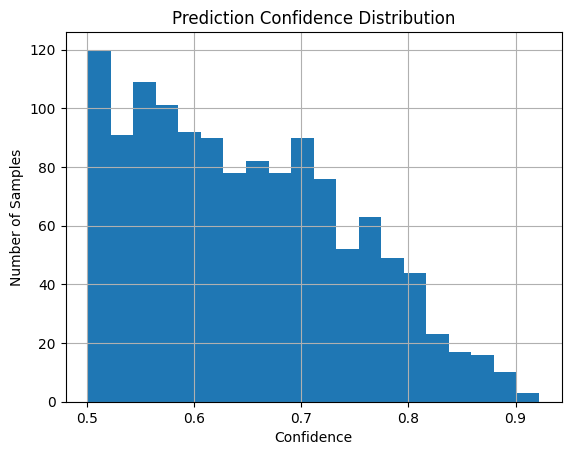

In [35]:
plt.hist(confidences, bins=20)
plt.title("Prediction Confidence Distribution")
plt.xlabel("Confidence")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()

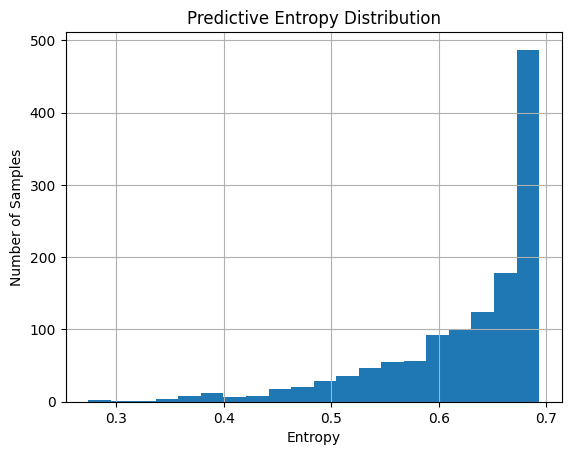

In [ ]:
plt.hist(entropies, bins=20)
plt.title("Predictive Entropy Distribution")
plt.xlabel("Entropy")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()

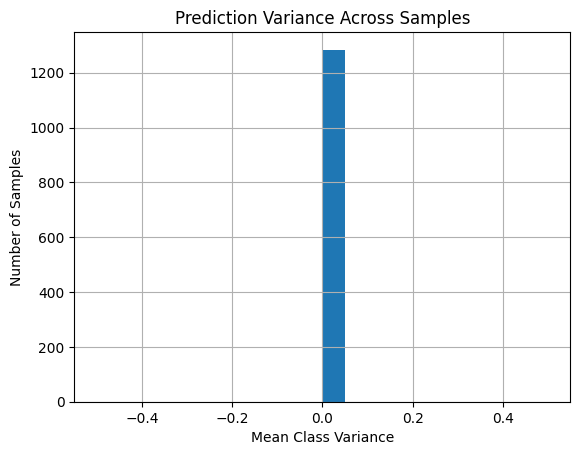

In [36]:
plt.hist(variances, bins=20)
plt.title("Prediction Variance Across Samples")
plt.xlabel("Mean Class Variance")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.show()